<a href="https://colab.research.google.com/github/Caduescanti/Analise-de-Dados-Airbnb/blob/main/ap3_LCD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Configuração do Ambiente
---

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from collections import Counter
from typing import Dict
import pandas as pd
import numpy as np
import math

---
# Entendendo o DataSet
---

Leitura do DataSet.

In [ ]:
df = pd.read_csv('https://data.insideairbnb.com/united-states/ny/new-york-city/2025-01-03/visualisations/listings.csv')

O DataSet contém registros de imóveis cadastrados na plataforma de aluguéis da concorrente, tendo as seguintes informações:  

| Coluna | Descrição |
| ------ | --------- |
| id | chave única para identificação do imóvel |
| name | nome do imóvel |
| host_id | chave única para o anfitrião do imóvel |
| host_name | nome do anfitrião do imóvel |
| neighbourhood_group | nome do bairro ao qual o imóvel pertence |
| neighbourhood | nome do sub-bairro ao qual o imóvel pertence |
| latitude | latitude do imóvel |
| longitude | longitude do imóvel |
| room_type | tipo de quarto (Casa/apto inteiro, Quarto privado, Quarto de Hotel ou Quarto compartilhado)
| price | preço da diária |
| minimum_nights | mínimo de noites necessárias para alugar |
| number_of_reviews | número de avaliações recebidas do imóvel |
| last_review | data da última avaliação recebida |
| reviews_per_month | média de avaliações mensais |
| calculated_host_listintgs_count | número de imóveis anunciados pelo mesmo anfitrião |
| availability_365 | número de dias em que o imóvel estará disponível pelos próximos 365 dias |
| number_of_reviews_ltm | total de avaliações nos últimos 12 meses |  
| license | licença para alugar o imóvel |

In [ ]:
# Visualizando uma amostra dos dados.
df.sample(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
27011,830675617804023987,The Spybox Suite @ Eighth House,76166434,Joel,Manhattan,Midtown,40.765970,-73.982680,Entire home/apt,NaN,30,0,NaN,NaN,3,365,0,NaN
28396,896486644984575401,The Brooklyn PINK,214760191,Ahmad,Brooklyn,East New York,40.679130,-73.879020,Entire home/apt,291.0,2,36,2024-12-28,1.86,1,116,13,OSE-STRREG-0001377
33398,1122341264871250207,Tiny Shared Bath Private Studio Times Square #208,35491667,Nat,Manhattan,Hell's Kitchen,40.760396,-73.991932,Entire home/apt,53.0,30,2,2024-12-19,0.58,129,249,2,NaN
13575,34743365,Modern and new Duplex next to A train,26319385,Ariadna,Brooklyn,Bedford-Stuyvesant,40.680100,-73.951770,Entire home/apt,NaN,30,0,NaN,NaN,1,0,0,NaN
31770,1052294182424144426,Essex House - Central Park View,536699718,Mighty Tree,Manhattan,Midtown,40.765488,-73.977778,Entire home/apt,378.0,30,0,NaN,NaN,1,364,0,NaN


---
# Limpeza e Pré-processamento dos Dados
---

Várias linhas contém valores nulos, para não gerar problemas nas análises, será analisado como os valores nulos estão distribuídos.

In [ ]:
for column in df.columns:
    nulos = len(df[df[column].isna()])
    print(f'{column}: {nulos}')

id: 0
name: 2
host_id: 0
host_name: 6
neighbourhood_group: 0
neighbourhood: 0
latitude: 0
longitude: 0
room_type: 0
price: 14815
minimum_nights: 0
number_of_reviews: 0
last_review: 11892
reviews_per_month: 11892
calculated_host_listings_count: 0
availability_365: 0
number_of_reviews_ltm: 0
license: 32398


---
Há alguns registros com o nome ou o host_name como nulo, como não há como deduzir estas informações, será apenas colocado um nome default.   


In [ ]:
df.fillna({'name': 'nameless'}, inplace=True)
df.fillna({'host_name': 'host_nameless'}, inplace=True)

Já em registros sem reviews, os valores de 'last_review' e 'reviews_per_month' ficam como nulo, em última review, não há oque fazer pois não se pode definir uma data zero como última review, mas em reviews por mês, é possível estabelecer como substituto aos nulos, o valor 0.

In [ ]:
df.fillna({'reviews_per_month': 0}, inplace=True)
df.fillna({'last_review': 0}, inplace=True)

A coluna 'last_review' têm as datas como string, estas serão convertidas para datetime para melhor manipulação das datas.

In [ ]:
df['last_review'] = pd.to_datetime(df['last_review'], format='%Y-%m-%d', errors='coerce')

Para preencher os nulos na coluna price podemos fazer a mediana por neighbourhood e room_type já que influenciam diretamente no preço.

In [ ]:
df['price'] = df.groupby(['neighbourhood', 'room_type'])['price'].transform(lambda x: x.fillna(x.median()))
print(df['price'].isnull().sum())

48


Como ainda sobraram 48 nulos após a mediana podemos preencher com a media geral dos preços.

In [ ]:
df['price'] = df['price'].fillna(df['price'].median())
print(df['price'].isnull().sum())

0


---
# Análise Exploratória dos Dados
---

## Temos 4 tipos de dados no DataSet:

*   Categóricos:
    *   bairro_group
    *   bairro
    *   room_type
    *   id
    *   nome
    *   host_id
    *   host_name
    *   license

*   Numéricos:
    *   price
    *   minimo_noites
    *   numero_de_reviews
    *   reviews_por_mes
    *   calculado_host_listings_count
    *   disponibilidade_365
    *   number_of_reviews_ltm
    
* Temporais:
    *   ultima_review

* Geográficos:
    *   latitude
    *   longitude


Entretando nem todos trazem informações importantes, como id, host_id e host_name. Estes serão deixados de lado nas análises.

---

## Variáveis categóricas

Para as variáveis categóricas, uma ótima forma de ver como os valores estão distribuídos é através de um gráfico de colunas, que permite visualizar a ocorrência de cada valor. Quando existem muitas categorias, a visualização fica difícil, então são selecionados apenas uma parte dos valores mais ocorrentes para a visualiação.

In [ ]:
def barhplot(df: pd.DataFrame, column: str, ax: plt.Axes, title: str, max: int=-1) -> None:
    contagem = df[column].value_counts().iloc[:max]
    ax.barh(contagem.index, contagem.values)

    for i, valor in enumerate(contagem.values):
        if column == 'nome':
            ax.text(valor + 0.1, i, valor, va='center')
        else:
            porcentagem = (valor / df.shape[0]) * 100
            ax.text(valor + 0.1, i, f'{porcentagem:.2f}%', va='center')

    ax.invert_yaxis()
    ax.set_xlabel('Ocorrência')
    ax.set_title(title)

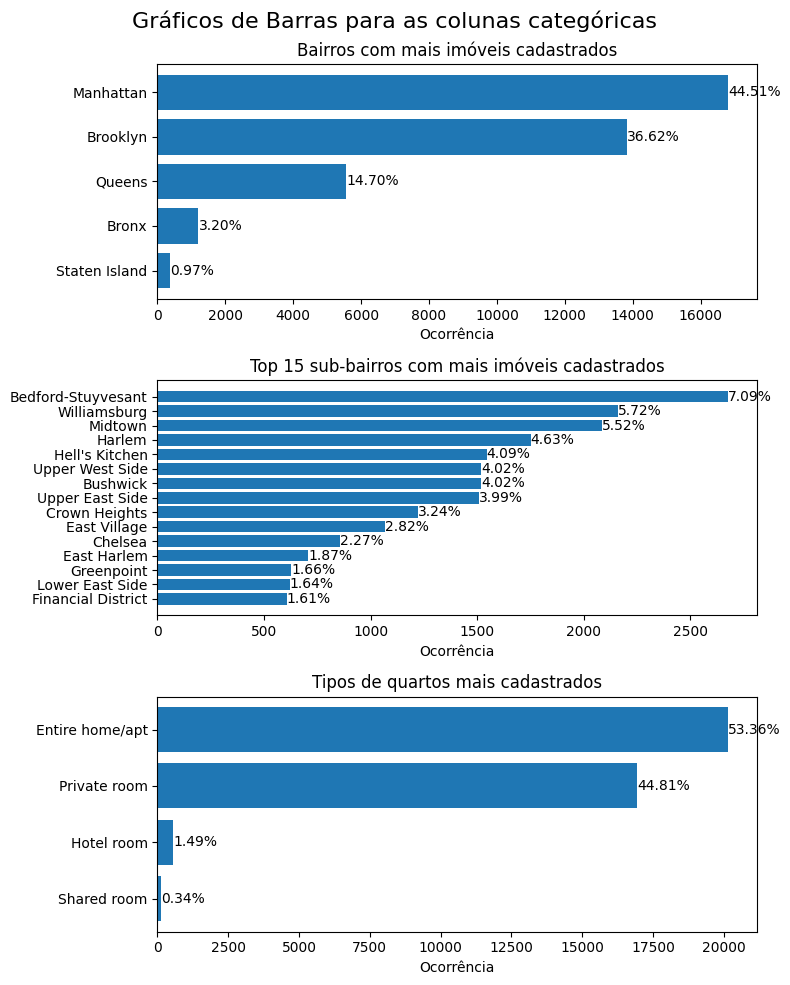

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(8, 10))
axs = axs.flatten()

columns = ['neighbourhood_group', 'neighbourhood', 'room_type']
titles = ['Bairros com mais imóveis cadastrados', 'Top 15 sub-bairros com mais imóveis cadastrados',
          'Tipos de quartos mais cadastrados']
for i, column, title in zip(range(4), columns, titles):
    barhplot(df, column, axs[i], title, 15)

plt.suptitle('Gráficos de Barras para as colunas categóricas', fontsize=16)
plt.tight_layout()
plt.show()

### Insights

#### Bairros com mais imóveis
Temos 5 bairros em Nova York: Manhattan, Brooklyn, Queens, Bronx e Staten Island.  
Porem, só os bairros Manhattan e Brooklyn contém mais de 81% dos imóveis cadastrados, e se somados ao Queens, contém mais de 95% dos imóveis, mostrando uma forte concentração nestes bairros.

#### Sub-bairros com mais imóveis
Há 221 sub-bairros no DataSet, porém, ao somar os 5 sub-bairros com mais imóveis, vamos encontrar mais de 30% dos imóveis cadastrados, e somando os 15 primeiros, encontramos 58.5% dos imóveis cadastrados.  
Dentre estes 15 bairros,

*   9 estão em Manhattan
*   6 estão no Brooklyn

Mostrando novamente que a maioria dos imóveis estão em Manhattan e no Brooklyn.

#### Tipos de quartos mais cadastrados
Entre os tipos de quartos, o mais frequente é o aluguel da casa/apt inteiro, e bem próximo, aluguel de apenas um quarto privado. É possível notar também que quartos compartilhados e de hotéis não são muito frequentes, sendo menos de 2% dos imóveis.

## Variáveis numéricas

Já para as variáveis numéricas, existem 2 gráficos principais para visualizar a distribuição dos dados, o histograma que define intervalos e faz um gráfico de colunas, tendo como categorias, os intervalos definidos, e o boxplot, que mostra dentre quais valores, os dados estão concentrados.  


---
No histograma, valores extremos podem atrapalhar na criação das categorias, então se forem poucos valores extremos, estes podem ser desconsiderados na visualização.

In [ ]:
def hist(df: pd.DataFrame, column: str, ax: plt.Axes, title: str, xlim: float, bins: int=35) -> None:
    data = df[df[column] < xlim][column]
    ax.hist(data, bins)

    q2 = df[column].quantile(0.5) + 0.5
    q3 = df[column].quantile(0.75) + 0.5
    ax.axvline(q2, color='r')
    ax.axvline(q3, color='g')

    ax.set_ylabel('Ocorrência')
    ax.set_title(title)

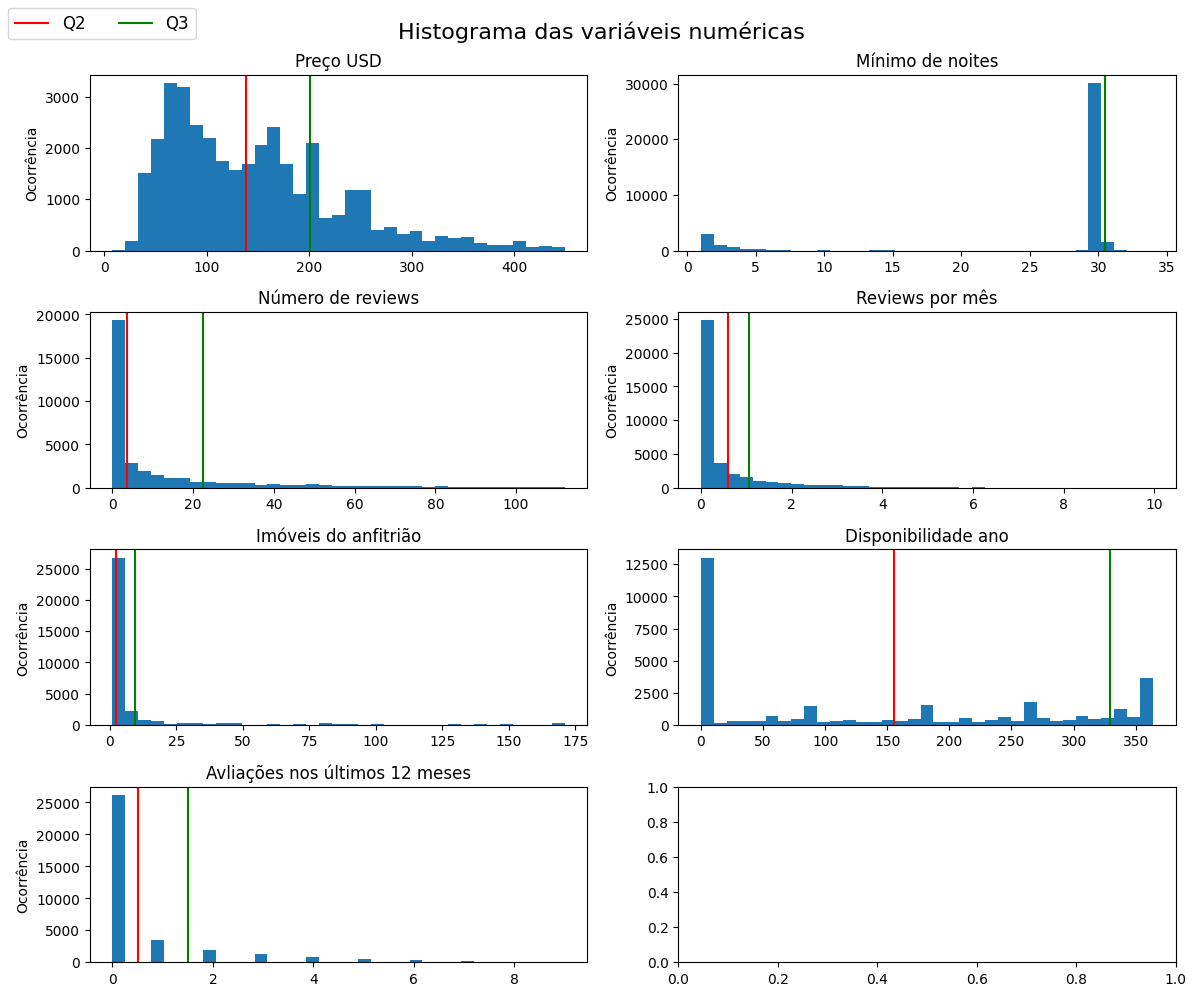

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(12, 10))
axs = axs.flatten()
params = [[0, 'price',                         'Preço USD',                450],
          [1, 'minimum_nights',                 'Mínimo de noites',      35],
          [2, 'number_of_reviews',             'Número de reviews',    113],
          [3, 'reviews_per_month',               'Reviews por mês',        10],
          [4, 'calculated_host_listings_count', 'Imóveis do anfitrião',  175],
          [5, 'availability_365',           'Disponibilidade ano',  365],
          [6, 'number_of_reviews_ltm',          'Avliações nos últimos 12 meses', 10]
]

for i, column, title, xlim in params:
    hist(df, column, axs[i], title, xlim)

plt.suptitle('Histograma das variáveis numéricas', fontsize=16)

fig.legend(['Q2', 'Q3'], loc='upper left', fontsize=12, ncol=2)
plt.tight_layout()
plt.show()

### Insights














**OBS**: Em todos os gráficos, foi representado mais de 90% do conjunto dos dados, portanto, a remoção de outliers não afeta a fidelidade dos gráficos em relação aos dados.

In [ ]:
for _, column, _, xlim in params:
    porcentagem = round(100* (df[column].dropna()<=xlim).mean(), 2)
    print(f'{column.ljust(30)}: {porcentagem}%')

price                         : 96.57%
minimum_nights                : 97.46%
number_of_reviews             : 93.9%
reviews_per_month             : 99.79%
calculated_host_listings_count: 90.17%
availability_365              : 100.0%
number_of_reviews_ltm         : 92.11%


#### Preço
É possível notar que a maioria dos preços está abaixo de 200, sendo o Q3 (linha verde) inferior a 200, ou seja, 75% dos preços estão abaixo de 200, e mais concentrados ainda estão os valores abaixo de 130 aproximadamente, que contém quase 50% dos preços.

#### Mínimo de noites
Em mais de 75% dos imóveis, o mínimo de noites é no máximo 5, para os demais valores, percebe-se uma redução, no entanto há um pico onde o mínimo de noites são 30, aproximadamente 100 imóveis.

#### Número de reviews
50% dos imóveis tem 0 ou 1 avaliações, indicando que as pessoas tendem a alugar imóveis com um histórico maior de uso.
Em seguida, a distribuição do número de reviews se dispersa, estando o Q2 em aproximadamente 25 reviews.

#### Reviews por mês
50% dos imóveis tem menos de 1 reviews por mês, e 75% tem menos de 21 reviews por mês, mostrando que muitos imóveis não estão sendo utilizados.

#### Imóveis do anfitrião
Em mais 50% dos imoveis, o anfitrião só tem 1 imóvel anunciado, e em 75%, o anfitrião tem no máximo 10 imóveis anunciados aproximadamente, mostrando que a maioria dos anfitriões são provavelmente pessoas físicas que não tem no aluguel de imóveis sua principal fonte de renda.

#### Disponibilidade ano
50% dos imóveis está disponível em menos de 150 dias dos próximos 365 dias, provavelmente pessoas que irão viajar nas férias e querem deixar a casa alugada no período e 75% estará disponível em aproximadamente 340 dias, neste caso, provavelmente há muitas pessoas que utilizam do imóvel como estadia no período de férias, mas quando estão fora, deixam o imóvel disponível para aluguel.

---

## Variáveis Temporais

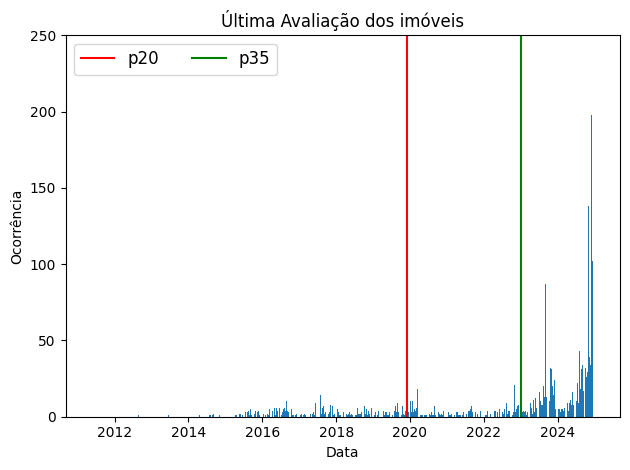

In [ ]:
contagem = df['last_review'].value_counts()
plt.bar(contagem.index, contagem.values)

p20 = df['last_review'].quantile(0.2)
p35 = df['last_review'].quantile(0.35)
plt.axvline(p20, color='r')
plt.axvline(p35, color='g')

plt.legend(['p20', 'p35'], loc='upper left', fontsize=12, ncol=2)
plt.xlabel('Data')
plt.ylabel('Ocorrência')
plt.title('Última Avaliação dos imóveis')
plt.ylim(0, 250)
plt.tight_layout()
plt.show()

Como podemos notar, a maioria dos imóveis estão sendo avaliados a partir do ano de 2024, sendo mais especifico a partir de novembro.Nesse sentido, um dos motivos para isso pode ser o crescimento na facilidade de realizar as avaliações e o inicio da temporada de férias.

<ipython-input-20-473feceb0f89>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', fontsize=12)


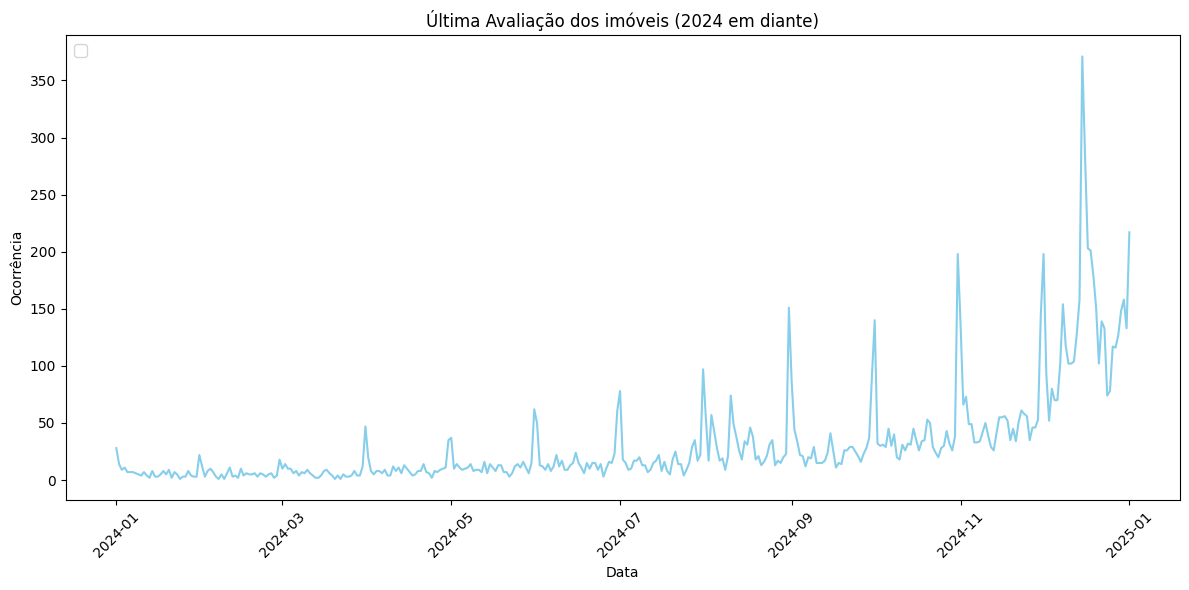

In [ ]:
df_filtered = df[(df['last_review'] >= '2024') & (df['last_review'] <= '2025-01')]

contagem = df_filtered['last_review'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.plot(contagem.index, contagem.values, color='skyblue')

plt.xticks(rotation=45)
plt.legend(loc='upper left', fontsize=12)
plt.xlabel('Data')
plt.ylabel('Ocorrência')
plt.title('Última Avaliação dos imóveis (2024 em diante)')
plt.tight_layout()
plt.show()


## Variáveis Geométricas

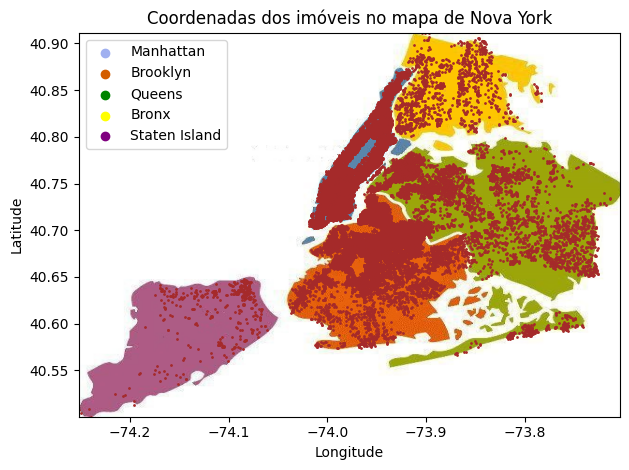

In [ ]:
img = mpimg.imread('mapa.jpg')

fig, ax = plt.subplots()
x_min, x_max = df['longitude'].min(), df['longitude'].max() + 0.01
y_min, y_max = df['latitude'].min(), df['latitude'].max()

ax.imshow(img, extent=[x_min, x_max, y_min, y_max], aspect='auto')
ax.scatter(df['longitude'], df['latitude'], s=1, c='brown')
cores = ['#A0B0F0', '#D35D00', '#008400', 'yellow', 'purple']
bairros = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']

for cor, bairro in zip(cores, bairros):
    ax.scatter([], [], c=cor, label=bairro)
ax.legend(loc='best')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Coordenadas dos imóveis no mapa de Nova York')
plt.tight_layout()
plt.show()

Analisando o gráfico de dispersão, percebe-se uma concentração significativa nos bairros: Manhattan, Queens e Brooklyn, fundamentando o que foi apresentado no gráfico de barras 'Bairros com Mais Imóveis Cadastrados'.

## Verificando a correlação entre as variáveis

<ipython-input-26-3113f14989b6>:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 2000x1000 with 0 Axes>

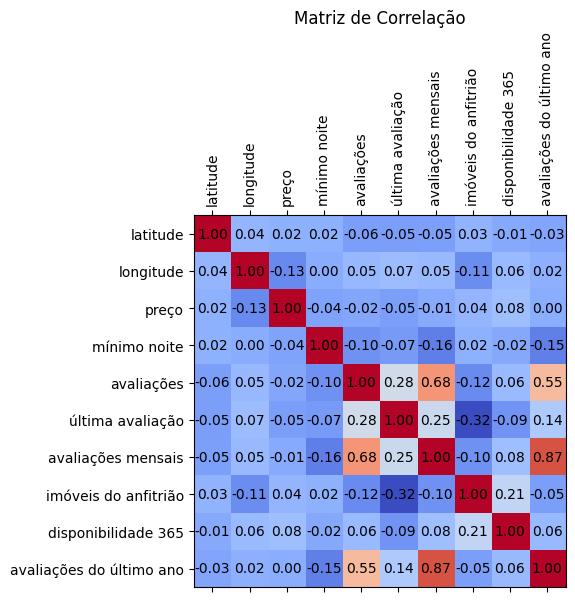

In [ ]:
plt.figure(figsize=(20, 10))
corr = df.drop(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'room_type', 'license'], axis='columns').corr()
corr.columns = ['latitude', 'longitude', 'preço', 'mínimo noite', 'avaliações', 'última avaliação', 'avaliações mensais',
                'imóveis do anfitrião', 'disponibilidade 365', 'avaliações do último ano']

cax = plt.matshow(corr, cmap='coolwarm')

plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)

for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        plt.text(j, i, f'{corr.iloc[i, j]:.2f}', ha='center', va='center', color='black')

plt.title('Matriz de Correlação')
plt.tight_layout()
plt.show()

É possível ver que as variáveis que mais se relacionam entre si são:
* avaliações mensais x avaliações (0.68)
* avaliações  x avaliações do último ano (0.55)
* avaliações do último ano x avaliações mensais (0.87)

Oque faz sentido, já que todas se referem ao mesmo assunto.

Ao que se refere ao preço, oque as variáveis mais relacionadas com o preço são:
* Longitude (-0.13)
* disponibilidade 365 (0.08)
* última avaliação (-0.05)

## Conclusão

Após todas as análises realizadas e uma reunião com o nosso cliente, explicamos que alguns locais não possuíam licença para aluguel, mas ele se mostrou disposto a se responsabilizar pela obtenção dessas licenças, caso a aquisição do imóvel fosse vantajosa para ele. Dito isso, ele optou por tentar a aquisição de imóveis localizados nos bairros: Bronx, Manhattan e Queens, com as seguintes condições:

- A taxa de preço dos aluguéis fosse inferior a 75%.
- O número total de avaliações e o número mensal de avaliações fossem superiores a 50%, para garantir que ele teria informações mais detalhadas sobre cada imóvel.
- O tempo de disponibilidade desses imóveis fosse superior a 300 dias, pois seria mais fácil adquirir imóveis que não fossem muito utilizados pelos donos.
- Ele pediu também a retirada dos imóveis classificados como "quartos de hotel", pois além de não serem procurados, ele não tinha interesse nesses locais.
- Por fim, pediu a exclusão dos "quartos compartilhados", pois, segundo ele, seriam pouco rentáveis.

In [ ]:
df_filtrado = df[df['price'] < df['price'].quantile(0.75)]
df_filtrado = df_filtrado[df_filtrado['number_of_reviews'] > df_filtrado['number_of_reviews'].quantile(0.5)]
df_filtrado = df_filtrado[df_filtrado['reviews_per_month'] > df_filtrado['reviews_per_month'].quantile(0.5)]
df_filtrado = df_filtrado[df_filtrado['availability_365'] > 300]
df_filtrado = df_filtrado[(df_filtrado['room_type'] == 'Entire home/apt') | (df_filtrado['room_type'] == 'Private room')]
df_filtrado = df_filtrado[(df_filtrado['neighbourhood_group'] == 'Bronx') | (df_filtrado['neighbourhood_group'] == 'Manhattan') | (df_filtrado['neighbourhood_group'] == 'Queens')]

In [ ]:
print(len(df_filtrado[df_filtrado["license"].isna()]))

427


Com base nos critérios estabelecidos pelo cliente, a base de dados resultante contém 770 imóveis. Desses, 427 imóveis não possuem licença para aluguel, o que indica que mais da metade dos imóveis selecionados não atendem a esse requisito.

In [ ]:
df_filtrado

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
22,18728,Beautiful Meatpacking District Loft,71876,DAVID And RICK,Manhattan,Chelsea,40.742610,-74.003530,Private room,150.0,30,250,2024-11-15,1.49,1,346,4,NaN
31,23545,Upper Upper West Side Garden Apartment Townhouse,92411,Karen,Manhattan,Harlem,40.828250,-73.951380,Entire home/apt,200.0,30,215,2019-06-17,1.20,1,358,0,NaN
105,54860,Bedroom in my apartment with a private bathroom.,258164,Jenny,Manhattan,East Harlem,40.799340,-73.942360,Private room,125.0,30,304,2024-10-19,1.76,1,339,2,NaN
135,66275,Lower East Side Magic Apartment Entire Apartme...,314941,Tony,Manhattan,Nolita,40.720360,-73.994350,Entire home/apt,199.0,30,211,2023-06-21,1.28,3,365,0,NaN
151,80493,Cozy room in East Village with AC,434987,Jennifer,Manhattan,East Village,40.722613,-73.985459,Private room,70.0,30,233,2024-02-01,1.39,1,363,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35944,1229182096342551645,AJ lovely room,594783954,Ajay,Queens,Springfield Gardens,40.665210,-73.770441,Private room,63.0,1,22,2024-12-27,9.57,2,343,22,OSE-STRREG-0002622
36149,1242898939814869156,Centrally Located APT in NYC / Walk to Time Sq...,577073225,Noelle,Manhattan,Midtown,40.755080,-73.981060,Entire home/apt,207.0,1,15,2024-12-19,4.95,1,351,15,Exempt
36315,1249410420110430995,Large Room In Shared Manhattan Apartment,92344631,Marjolie,Manhattan,Harlem,40.819996,-73.942951,Private room,200.0,3,10,2024-12-16,3.66,2,364,10,OSE-STRREG-0002568
36492,1258267990600001591,"Charming, airy and elegant!\nNew York",598810246,Mohamed Fazal Abid,Queens,Jamaica,40.702716,-73.786920,Private room,144.0,1,12,2024-12-31,4.04,2,365,12,OSE-STRREG-0002582
